In [ ]:
# first some initial setup of libraries we will be using
import pandas as pd # this is the main library used in python for manipulating data. 
import json # this is a library to parse json (javascript object notation)
from urllib.request import urlopen # library to read data from a URL
import matplotlib.pyplot as plt # visualization library we will use that integrates with pandas
import seaborn as sns

In [ ]:
# We are reading in the data we want from ACS 2021. The API returns json data. Try copy and pasting the link yourself in a browser to see what the raw data looks like.
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,B19001_001E,B19001_002E,B19001_017E&for=congressional%20district:*&in=state:*"

# store the response of URL
response = urlopen(url)

# storing the JSON response from url in data
data_json = json.loads(response.read())
data_json.pop(0) # the first row of data is header information which we don't need, so pop removes that from the dataset.

# Hand populate the columns based on the variable descriptions census.gov documents here: https://api.census.gov/data/2021/acs/acs1/variables.html. Note they correspond back to the variable names I included in the URL above.
cols = ['District Name','Total Households','Less than $10k', '$200k+', 'State code', 'district number']

acs_df = pd.DataFrame(data_json, columns = cols)

# time to do some basic cleanup of the data. We will need to extract the district number and state in a regular format so we can later join with the party data.
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])

acs_df['State'] = acs_df['State'].str.strip()

# Let's just keep the columns we need
acs_df = acs_df[['Total Households', 'Less than $10k', "$200k+", 'district number', 'State']]

# take a look at the top results in the dataset
acs_df.head()

,Total Households,Less than $10k,$200k+,district number,State
0,289474,14153,19390,10,Michigan
1,299804,23793,10899,4,Mississippi
2,278057,27728,19574,14,Michigan
3,306685,19036,12208,1,Michigan
4,285554,26481,12412,3,Mississippi


In [ ]:
acs_df.shape

(437, 5)

In [ ]:
# Convert the number columns into number data types so we can math on them
acs_df["Total Households"] = pd.to_numeric(acs_df["Total Households"])
acs_df["Less than $10k"] = pd.to_numeric(acs_df["Less than $10k"])
acs_df['$200k+'] = pd.to_numeric(acs_df['$200k+'])

# Compute some new columns based on the existing columns for later visualization
acs_df['% of households over $200k'] = (100*acs_df['$200k+'])/acs_df['Total Households']
acs_df['% of households less than $10k'] = (100*acs_df['Less than $10k'])/acs_df['Total Households']


In [ ]:
# read from the congressional data and put into a pandas dataframe
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")

# extract the district number from the data (it was in the format of 5th and we want that to just be 5) using a regular expression.
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() # remove extraneous whitespace

# Let's just keep the columns we need
party_df = party_df[['State', 'Party', "district number"]]

In [ ]:
# Merge is like a sql natural join. We are joining on the State and District numbers being the same between the two sets.
merged_df = pd.merge(acs_df, party_df, on=["State", "district number"])

In [ ]:
merged_df.describe()

,Total Households,Less than $10k,$200k+,district number,% of households over $200k,% of households less than $10k
count,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000
mean,292471.643678,17605.977011,28522.944828,10.158621,9.721602,6.050237
std,33670.787672,6047.931263,18902.411362,10.656779,6.417955,2.106075
min,183319.000000,6021.000000,5296.000000,0.000000,2.025905,2.208934
25%,273747.000000,13416.000000,14916.000000,3.000000,5.184740,4.653305
50%,292311.000000,16617.000000,22543.000000,6.000000,7.618205,5.679285
75%,311849.500000,21013.500000,37009.500000,13.000000,12.689262,7.036059
max,448949.000000,44929.000000,111988.000000,53.000000,41.846370,16.858153


In [ ]:
# let's take a look at the party breakdown and sanity check that it looks right
merged_df['Party'].value_counts()

D    233
R    201
L      1
Name: Party, dtype: int64

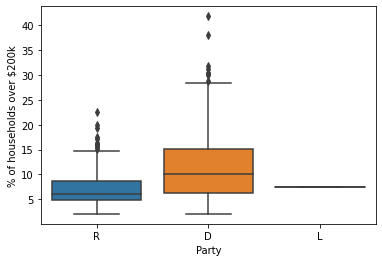

In [ ]:
# create plot
ax = sns.boxplot(x="Party", y="% of households over $200k", data= merged_df)

# show plot
plt.show()



In [ ]:
repMean = merged_df.loc[merged_df["Party"] == "R","% of households over $200k"].mean()

repMean

7.301120025713131

In [ ]:
demMean = merged_df.loc[merged_df["Party"] == "D","% of households over $200k"].mean()

demMean

11.819200263408232

In [ ]:
libMean = merged_df.loc[merged_df["Party"] == "L","% of households over $200k"].mean()

libMean

7.4980428942404185